In [11]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import random
import torch

import os

def set_seed(seed=1234):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [13]:
# -----------------------------------
# 1) Transforms
# -----------------------------------
img_size = (256, 256)

# Se o seu modelo é uma CNN simples que você fez do zero,
# geralmente é mais fácil trabalhar com 1 canal:
#   in_channels = 1 na primeira camada conv.
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=1),  # converte RGB OU grayscale para 1 canal P&B
    transforms.ToTensor()
    # sem Normalize por enquanto, pra não "escurecer" visualmente
])

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# -----------------------------------
# 2) Dataset base (sem transform)
# -----------------------------------
# path vem do kagglehub.dataset_download(...)
base_dataset = datasets.ImageFolder(path)  # NÃO coloca transform aqui

# -----------------------------------
# 3) Split treino / teste
# -----------------------------------
train_size = int(0.8 * len(base_dataset))
test_size = len(base_dataset) - train_size

train_subset, test_subset = random_split(
    base_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # divisão reprodutível
)

# -----------------------------------
# 4) Wrapper pra aplicar transform em cada subset
# -----------------------------------
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]  # img é PIL (pode vir RGB ou P&B)
        if self.transform:
            img = self.transform(img)  # aqui vira sempre 1×256×256, em P&B
        return img, label

train_dataset = SubsetWithTransform(train_subset, transform=transform_train)
test_dataset  = SubsetWithTransform(test_subset,  transform=transform_test)

# -----------------------------------
# 5) DataLoaders
# -----------------------------------
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

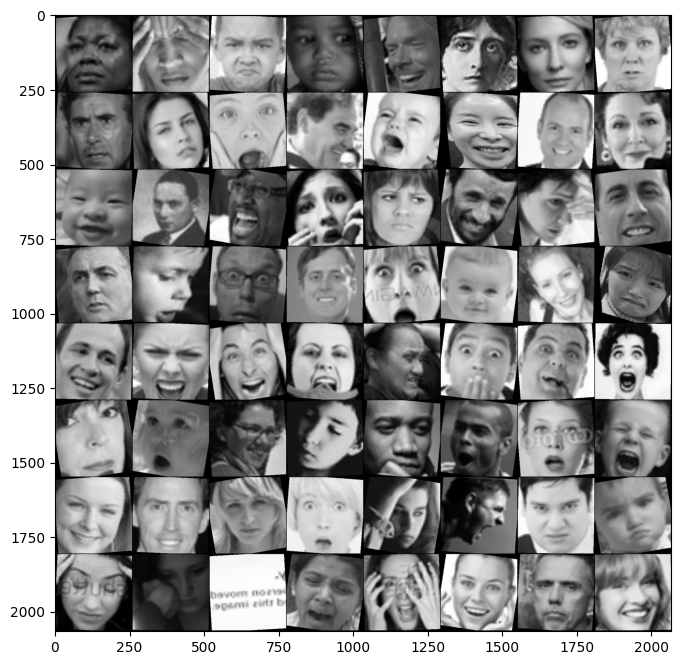

In [14]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

In [15]:
resnet = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)

In [16]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# substituímos a última camada da rede para resolver o nosso problema de classificação
resnet.fc = nn.Linear(2048,2)

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# "congelamos os pesos das camadas, exceto a última"
for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False
# for name, params in resnet.named_parameters():
#     print(name, params.requires_grad)

In [20]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 3

In [23]:
train(resnet, trainloader, testloader, optimizer, criterion, epochs)

NameError: name 'train' is not defined

In [ ]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)